### Imports

In [7]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from cmdstanpy import CmdStanModel
import cmdstanpy
import numpy as np
from scipy.stats import invgamma
from scipy.stats import norm
from scipy.special import softmax
from gptools.stan import get_include

import pandas as pd
from glob import glob
from nteprsm import utils 
from cmdstanpy import stanfit
from settings import ROOT_DIR
import plotly.express as px
import utils as notebook_utils
# use customize plotly template
notebook_utils.set_custom_template()

import pickle

import seaborn as sns
from scipy.interpolate import interp1d  # For interpolating synthetic seasonality


### Load Data

In [2]:
savename = '22_01_2025' ## Change this to whatever you saved the extracted samples under

In [4]:
with open(f"fit_{savename}.pkl", "rb") as f:
    fit = pickle.load(f)

with open(f"df_{savename}.pkl", "rb") as f:
    df = pickle.load(f)

with open(f"gpgrid_{savename}.pkl", "rb") as f:
    gp_grid = pickle.load(f)

with open(f"taus_{savename}.pkl", "rb") as f:
    taus = pickle.load(f)

In [22]:
num_entries = len(df['entry_name_code'].unique())
num_rows = int(df['row'].max())  # Maximum row index
num_cols = int(df['col'].max())  # Maximum column index
num_raters = fit.tau_rater.shape[1]  # Number of raters
num_betas = fit.tau_rater.shape[2]   # Number of beta values (should be 8)


### Seasonality

In [11]:
## visualization parameters
ci = 0.95

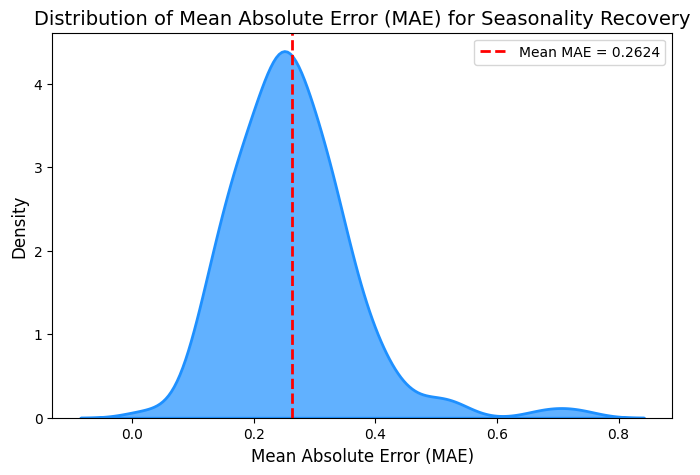

In [12]:
seasonality_means = fit.pred_time_effect.mean(axis=0)
seasonality_upper = np.quantile(fit.pred_time_effect, ci/2 + 1/2, axis=0)
seasonality_lower = np.quantile(fit.pred_time_effect, (1 - ci)/2, axis=0)

# Loop through the 3 random values of `ec` and plot
maes = []
time_points = np.linspace(0, 1, 100)  # Normalized time= []

for ec in range(147):
    # Filter the data for the current `ec`
    data = df[df['entry_name_code'] == ec][['adj_time_of_year', 'SEASONALITY']].drop_duplicates()
    
    # Compute Mean Absolute Error (MAE)
    synthetic_time = data['adj_time_of_year'].values
    synthetic_seasonality = data['SEASONALITY'].values

    # Interpolate synthetic seasonality to match recovered time points
    interp_func = interp1d(synthetic_time, synthetic_seasonality, kind='cubic', fill_value="extrapolate")
    interpolated_synthetic = interp_func(time_points)
    mae = np.mean(np.abs(seasonality_means[ec] - interpolated_synthetic))
    maes.append(mae)

# KDE Plot of Mean Absolute Errors (MAEs)
plt.figure(figsize=(8, 5))
sns.kdeplot(maes, fill=True, color="dodgerblue", linewidth=2, alpha=0.7)

# Add title and labels
plt.title("Distribution of Mean Absolute Error (MAE) for Seasonality Recovery", fontsize=14)
plt.xlabel("Mean Absolute Error (MAE)", fontsize=12)
plt.ylabel("Density", fontsize=12)

# Add a vertical line for the mean MAE
mean_mae = np.mean(maes)
plt.axvline(mean_mae, color="red", linestyle="--", linewidth=2, label=f"Mean MAE = {mean_mae:.4f}")

# Add legend
plt.legend()

# Show plot
plt.show()

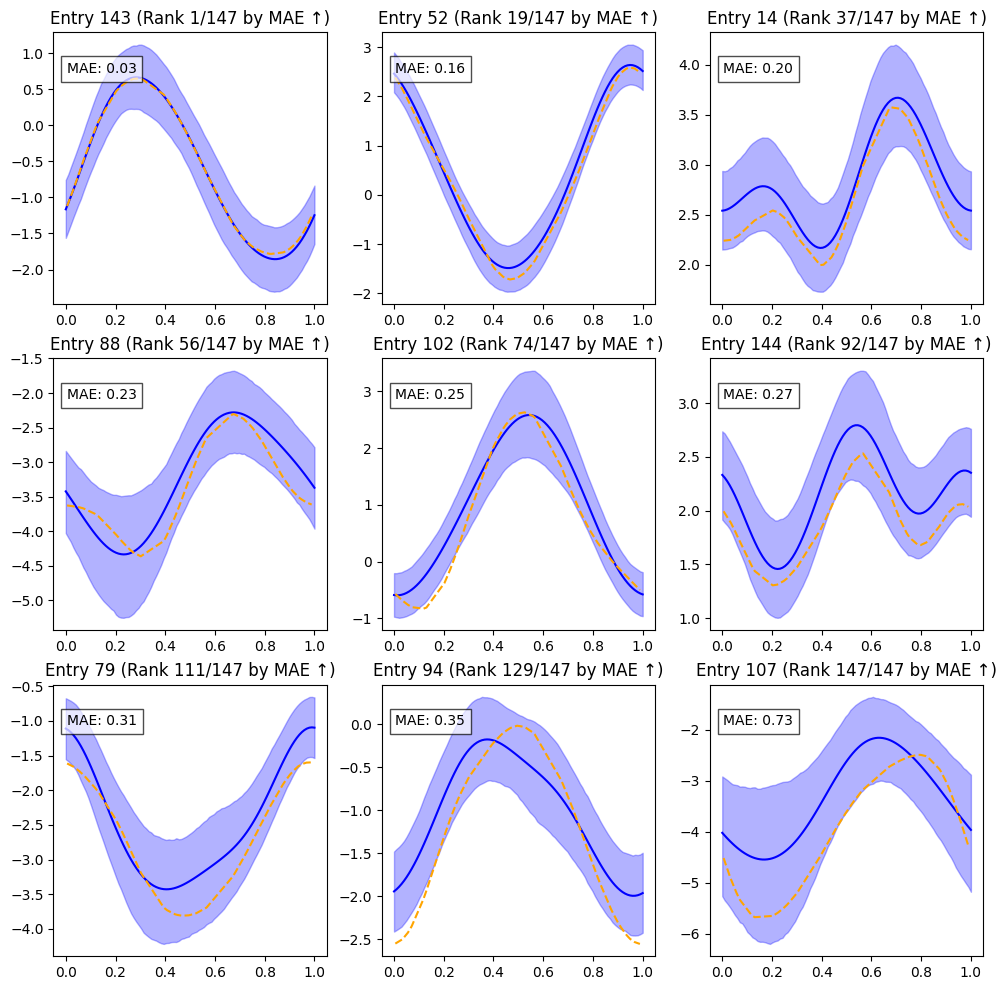

In [17]:
import numpy as np

# Visualization Parameters
ci = 0.95
nrows = 3
ncols = 3

ecs = []
ranks = []

for q in np.linspace(0, 1, nrows*ncols, endpoint=True):
    data = np.array(maes) 
    sorted_data = np.sort(data)
    
    # Compute the quantile value
    quantile_value = np.quantile(sorted_data, q)

    # Find the index of the closest value in the original unsorted data
    index = np.argmin(np.abs(data - quantile_value))
    index_sorted = np.argmin(np.abs(sorted_data - data[index]))
    ecs.append(index)
    ranks.append(index_sorted)

### visualization generation
sample_count = nrows*ncols

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 12))  # Adjust `figsize` as needed

# Flatten the axes array for easier iteration
axes = axes.flatten()

seasonality_means = fit.pred_time_effect.mean(axis=0)
seasonality_upper = np.quantile(fit.pred_time_effect, ci/2 + 1/2, axis=0)
seasonality_lower = np.quantile(fit.pred_time_effect, (1 - ci)/2, axis=0)

handles, labels = [], []

# Loop through the 3 random values of `ec` and plot
for i, ec in enumerate(ecs):
    time_points = np.linspace(0, 1, 100)  # Normalized time
    # Plot the sampled means    
    line1, = axes[i].plot(time_points, seasonality_means[ec], color='blue', label='Recovered Seasonality')
    #axes[i].plot(time_points, seasonality_means[ec], label='Recovered Seasonality')
    
    # Filter the data for the current `ec`
    data = df[df['entry_name_code'] == ec][['adj_time_of_year', 'SEASONALITY']].drop_duplicates()
    
    # Compute Mean Absolute Error (MAE)
    synthetic_time = data['adj_time_of_year'].values
    synthetic_seasonality = data['SEASONALITY'].values

    # Interpolate synthetic seasonality to match recovered time points
    interp_func = interp1d(synthetic_time, synthetic_seasonality, kind='cubic', fill_value="extrapolate")
    interpolated_synthetic = interp_func(time_points)

    # Plot the original data
    #axes[i].plot(data['adj_time_of_year'], data['SEASONALITY'], label='Synthetic Seasonality')
    line2, = axes[i].plot(synthetic_time, synthetic_seasonality, color='orange', linestyle='dashed', label='Synthetic Seasonality')
    fill = axes[i].fill_between(time_points, seasonality_lower[ec], seasonality_upper[ec], color='blue', alpha=0.3, label=f'{ci} credible interval')
    #axes[i].fill_between(time_points, seasonality_lower[ec], seasonality_upper[ec], where=(seasonality_upper[ec] >= seasonality_lower[ec]), interpolate=True, color='blue', alpha=0.3, label=f'{ci} credit interval')
    #plt.fill_between(x, y1, y2, where=(y1 < y2), interpolate=True, color='orange', alpha=0.3, label='sin(x) < cos(x)')
    
    mae = np.mean(np.abs(seasonality_means[ec] - interpolated_synthetic))
        # Store handles only once (from the first subplot)
    if i == 0:
        handles.extend([line1, line2, fill])
        labels.extend(['Recovered Seasonality', 'Synthetic Seasonality', f'{ci} Credible Interval'])
    
    # Add MAE annotation
    axes[i].text(0.05, 0.85, f"MAE: {mae:.2f}", transform=axes[i].transAxes, fontsize=10, bbox=dict(facecolor='white', edgecolor='black', alpha=0.7))

    # Set labels and title
    axes[i].set_title(f'Entry {ec} (Rank {ranks[i]+1}/{num_entries} by MAE ↑)')

### Spatial Effect

/tmp/ipykernel_1467/1582870458.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust to fit the colorbar


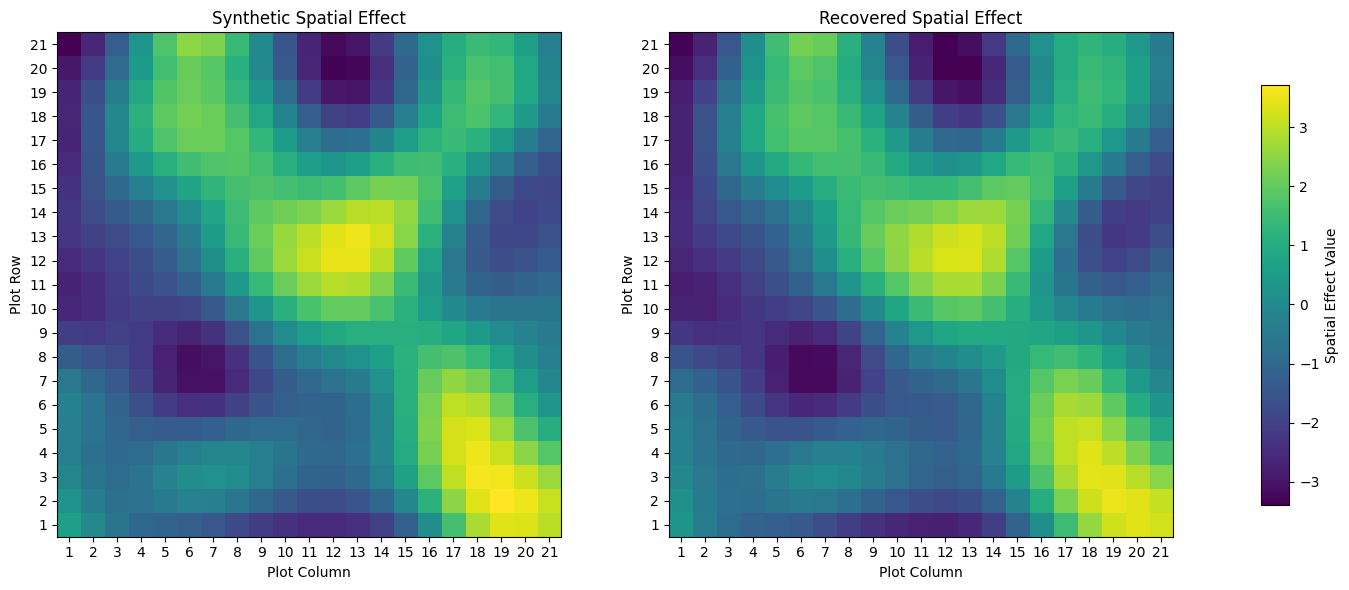

In [19]:
# Initialize a blank heatmap grid for the recovered effect
heatmap = np.zeros((num_rows, num_cols))

# Extract row and column mappings
grouped = df.groupby('plt_id')[['row', 'col']].mean()
rows = grouped.to_dict()['row']
cols = grouped.to_dict()['col']

# Get the mean recovered spatial effect values
plot_effect_means = fit.plot_effect.mean(axis=0)

# Populate the heatmap with recovered values
for i in range(len(plot_effect_means)):
    row = int(rows[i]) - 1
    col = int(cols[i]) - 1
    heatmap[row, col] = plot_effect_means[i]

# Determine a common color scale for both plots
vmin, vmax = min(gp_grid.min(), heatmap.min()), max(gp_grid.max(), heatmap.max())

# Create subplots (2 side-by-side)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={"width_ratios": [1, 1.05]})  # Ensure space for colorbar

# Plot synthetic spatial effect
im1 = axes[0].imshow(gp_grid, cmap="viridis", vmin=vmin, vmax=vmax, extent=(0, num_cols, 0, num_rows))
axes[0].set_title("Synthetic Spatial Effect")

# Plot recovered spatial effect
im2 = axes[1].imshow(heatmap, cmap="viridis", vmin=vmin, vmax=vmax, extent=(0, num_cols, 0, num_rows))
axes[1].set_title("Recovered Spatial Effect")

# Shared axis labels
for ax in axes:
    ax.set_xlabel("Plot Column")
    ax.set_ylabel("Plot Row")

# Set ticks to be in the middle of the squares
tick_positions = np.arange(0.5, num_cols, 1)  # Middle of each square
tick_labels = np.arange(1, num_cols + 1, 1)  # 1-based labels

for ax in axes:
    ax.set_xticks(tick_positions)
    ax.set_yticks(tick_positions)
    ax.set_xticklabels(tick_labels)
    ax.set_yticklabels(tick_labels)

# Add a single shared colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position the colorbar
fig.colorbar(im1, cax=cbar_ax, label="Spatial Effect Value")

# Improve layout
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust to fit the colorbar
plt.show()

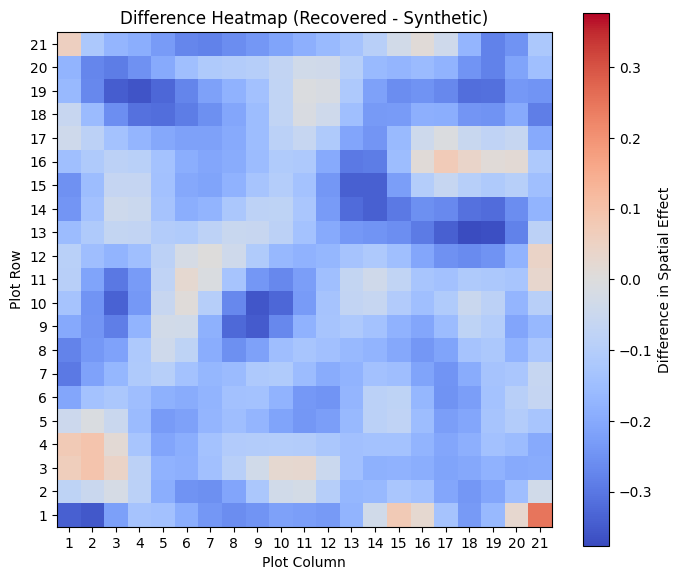

In [20]:
# Compute the difference heatmap (Recovered - Synthetic)
difference_heatmap = heatmap - gp_grid

# Set diverging color scale to center at 0
vmin, vmax = -max(abs(difference_heatmap.min()), abs(difference_heatmap.max())), max(abs(difference_heatmap.min()), abs(difference_heatmap.max()))

# Create figure
fig, ax = plt.subplots(figsize=(7, 6))

# Plot the difference heatmap
im = ax.imshow(difference_heatmap, cmap="coolwarm", vmin=vmin, vmax=vmax, extent=(0, num_cols, 0, num_rows))

# Add title and labels
ax.set_title("Difference Heatmap (Recovered - Synthetic)")
ax.set_xlabel("Plot Column")
ax.set_ylabel("Plot Row")

# Set ticks to be in the middle of the squares
tick_positions = np.arange(0.5, num_cols, 1)
tick_labels = np.arange(1, num_cols + 1, 1)

ax.set_xticks(tick_positions)
ax.set_yticks(tick_positions)
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)

# Add colorbar
cbar = fig.colorbar(im, ax=ax, label="Difference in Spatial Effect")

# Improve layout
plt.tight_layout()
plt.show()

### Beta Values

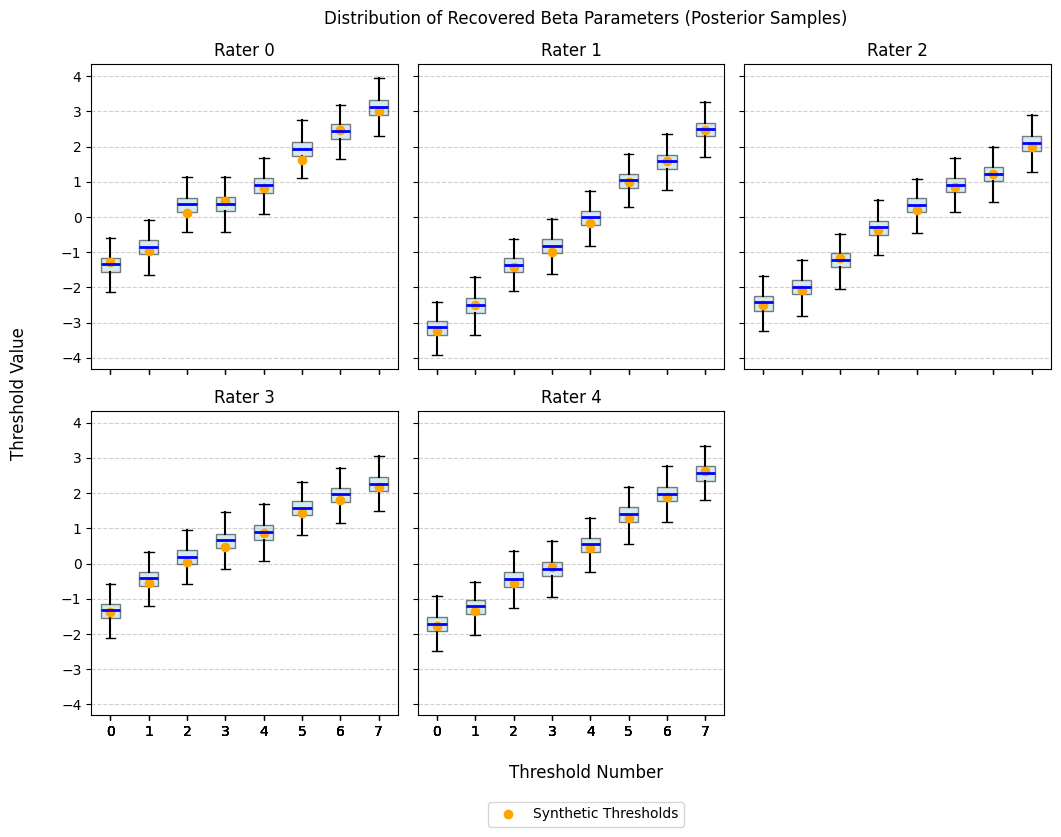

In [23]:
# Define grid layout
num_cols = min(3, num_raters)  # Max 3 columns for better readability
num_rows = int(np.ceil(num_raters / num_cols))  # Adjust rows based on total raters

fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows), sharex=True, sharey=True)

# Flatten axes array for easy iteration
axes = np.array(axes).flatten()

for i in range(num_raters):
    ax = axes[i]
    
    # Prepare box plot data: Each beta value has a distribution for this rater
    boxplot_data = [fit.tau_rater[:, i, j] for j in range(num_betas)]
    
    # Create the box plot
    ax.boxplot(boxplot_data, positions=np.arange(num_betas), patch_artist=True,
                showfliers=False,  # Hide outliers
                   boxprops=dict(facecolor="lightblue", alpha=0.5),
                   medianprops=dict(color="blue", linewidth=2),
                   whiskerprops=dict(linewidth=1.5))
    
    # Overlay synthetic thresholds as a dashed orange line
    ax.plot(np.arange(num_betas), taus[i], 'o', color='orange', label='Synthetic Thresholds')

    # Set title for each rater
    ax.set_title(f'Rater {i}')
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    
# Remove unused subplots (if num_raters is not a perfect multiple of num_cols)
for j in range(num_raters, len(axes)):
    fig.delaxes(axes[j])

# Add shared labels
fig.text(0.5, 0.02, "Threshold Number", ha="center", fontsize=12)  # X-axis label
fig.text(0.02, 0.5, "Threshold Value", va="center", rotation="vertical", fontsize=12)  # Y-axis label

fig.suptitle('Distribution of Recovered Beta Parameters (Posterior Samples)')

# Add a single legend outside the grid
handles, labels = ax.get_legend_handles_labels()
#fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.822, 0.41))
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3)
# Adjust layout
plt.tight_layout(rect=[0.05, 0.05, 0.9, 1])
plt.show()